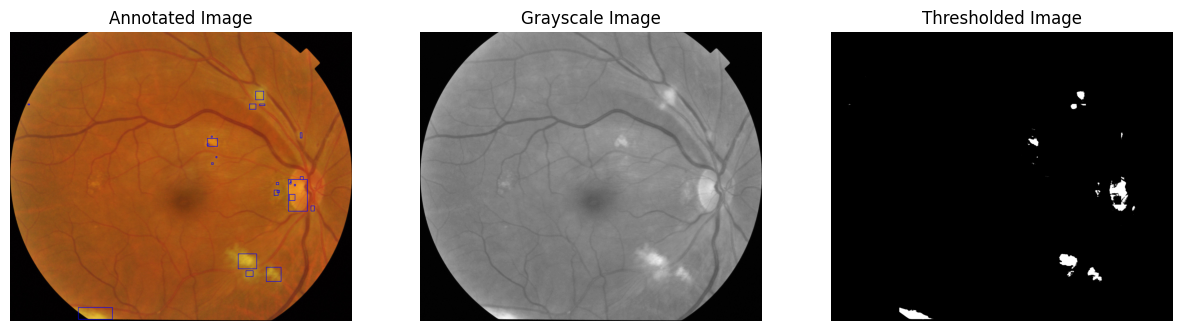

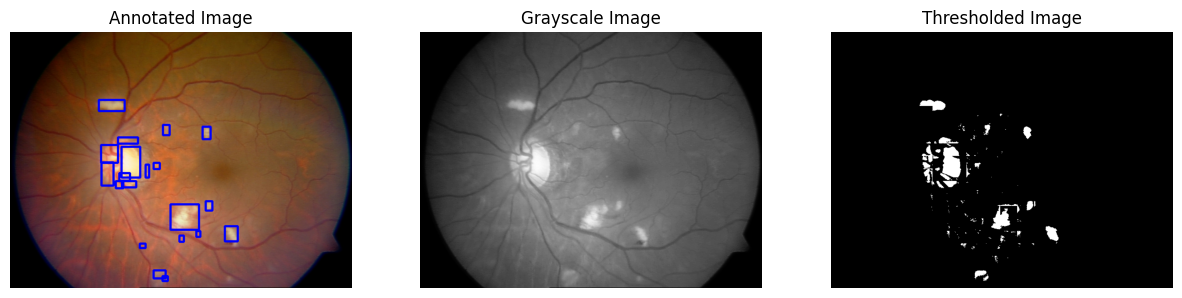

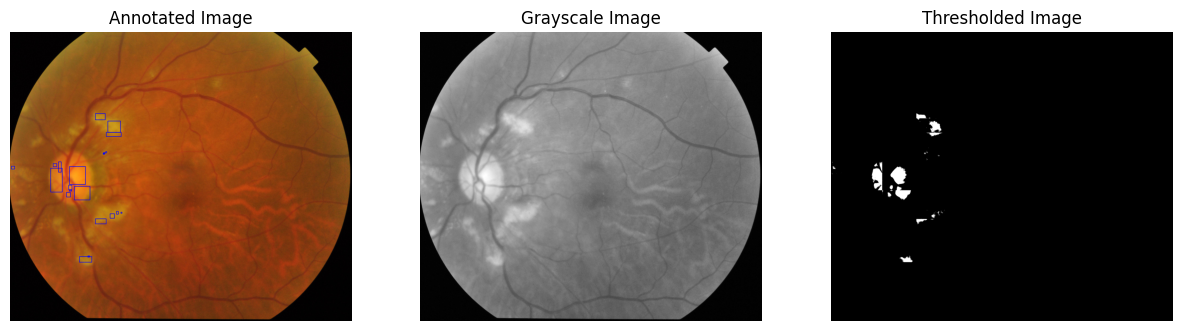

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

image_paths = ["1.JPG", "2.JPG", "3.JPG"] 
output_folder = "./annotated_images3"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def annotate_image(image_path, grid_size=(20, 20)): #here i devided the image into 400 regions (20*20),
    # after i tested diffrent values and approximitly 400 parts gets the best result so far
    # so instead of taking the whole brightness of the image, i calculated the best threshold of every region based on the brightness of that region, 
    # to detect anomalies even though they don't have the same intensity
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Get dimensions
    height, width = gray.shape
    region_height = height // grid_size[0]
    region_width = width // grid_size[1]
    
    # Initialize threshold image
    thresh = np.zeros_like(gray)
    
    # Process each region
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # region boundaries
            y_start = i * region_height
            y_end = (i + 1) * region_height
            x_start = j * region_width
            x_end = (j + 1) * region_width
            
            # Extract the region
            region = gray[y_start:y_end, x_start:x_end]
            
            # Calculate local mean brightness and threshold
            mean_brightness = np.mean(region)
            if mean_brightness < 108 : #i deleted the regions that have brightness too low, the black background around the fundus
                continue
            local_threshold = max(mean_brightness - 50, min(mean_brightness + 50, mean_brightness + 15))
            #here i made the min and amx values dynamic as well, (-50 and +50), but the final threshold value is still calculated manually, +15 is the best so far
            
            _, region_thresh = cv2.threshold(region, local_threshold, 255, cv2.THRESH_BINARY)
            
            # Place the thresholded region back into the image
            thresh[y_start:y_end, x_start:x_end] = region_thresh
    
    #the rest is the same
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        if w * h < 100: 
            continue
        
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3) 
    
    return img, gray, thresh


for image_path in image_paths:
    annotated_img, gray_img, thresh_img = annotate_image(image_path)
    
    output_path = f"{output_folder}/{image_path.split('/')[-1]}"
    cv2.imwrite(output_path, annotated_img)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Annotated Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(thresh_img, cmap="gray")
    plt.title("Thresholded Image")
    plt.axis("off")
    
    plt.show()